# 📊 Méthodes d'apprentissage classiques 📊

Dans ce notebook, nous testons différents modèles d'apprentissage automatique classiques en utilisant des plongements générés par TfidfVectorizer. Les modèles sont évalués à l'aide de la validation croisée à 5 plis.

Différents prétraitements (comme la suppression des mots outils et la lemmatisation) sont également testés afin d'identifier la combinaison de prétraitement et de modèle la plus performante.

Une fois la meilleure combinaison identifiée, le modèle est réentraîné sur l'ensemble des données d'apprentissage, puis testé sur les trois types de descriptions de notre jeu de données de test.

In [22]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from sklearn.compose import ColumnTransformer

# pour les modèles différents
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC

# pour la validation croisée
from sklearn import metrics
from sklearn import model_selection
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# pour la visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_colwidth', 600)

## 🗂️ Chargement des données

In [2]:
# Création du dossier data
!mkdir data
# Téléchargement des fichiers dans le dossier data
!wget -P data https://raw.githubusercontent.com/tpazakou/projet_apprentissage_automatique/refs/heads/main/data/test.csv
!wget -P data https://raw.githubusercontent.com/tpazakou/projet_apprentissage_automatique/refs/heads/main/data/train.csv

--2024-12-10 20:49:14--  https://raw.githubusercontent.com/tpazakou/projet_apprentissage_automatique/refs/heads/main/data/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 289798 (283K) [text/plain]
Saving to: ‘data/test.csv’

test.csv            100%[===================>] 283.01K  --.-KB/s    in 0.03s   

2024-12-10 20:49:14 (8.68 MB/s) - ‘data/test.csv’ saved [289798/289798]

--2024-12-10 20:49:14--  https://raw.githubusercontent.com/tpazakou/projet_apprentissage_automatique/refs/heads/main/data/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awai

In [3]:
dtypes = dtype= {'label_fr': 'category',
                 'description': 'object',
                 'description_tokens': 'object',
                 'description_wosw': 'object',
                 'description_lemmas': 'object',
                 'simple': 'object',
                 'simple_tokens': 'object',
                 'simple_wosw': 'object',
                 'simple_lemmas': 'object',
                 'fautes': 'object',
                 'fautes_tokens': 'object',
                 'fautes_wosw': 'object',
                 'fautes_lemmas': 'object'}
train_df = pd.read_csv("data/train.csv", sep = ",", index_col=False, dtype=dtypes)

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608 entries, 0 to 607
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   label_fr            608 non-null    category
 1   description         608 non-null    object  
 2   description_tokens  608 non-null    object  
 3   description_wosw    608 non-null    object  
 4   description_lemmas  608 non-null    object  
 5   simple              608 non-null    object  
 6   simple_tokens       608 non-null    object  
 7   simple_wosw         608 non-null    object  
 8   simple_lemmas       608 non-null    object  
 9   fautes              608 non-null    object  
 10  fautes_tokens       608 non-null    object  
 11  fautes_wosw         608 non-null    object  
 12  fautes_lemmas       608 non-null    object  
dtypes: category(1), object(12)
memory usage: 58.4+ KB


In [5]:
test_df = pd.read_csv("data/test.csv", sep = ",", index_col=False, dtype=dtypes)

## 💻 Choix du meilleur modèle

Les différents modèles sont entraînés sur la colonne `description`.



### **Données tokénisées, sans prétraitement :**

In [6]:
X_train = train_df[['description_tokens']]
y_train = train_df.label_fr

In [7]:
# fonction de tokénisation
def split_text(text) :
  # Les textes ayant déjà été pré-tokénisés, on découpe au niveau des espaces
  return text.split(' ')

In [8]:
# création de l'objet TfidfVectorizer
text_vectorizer = TfidfVectorizer(tokenizer=split_text,
                                  #la proportion minimale des documents dans lesquels un token doit se trouver, soit 1%
                                  min_df=0.01)

In [9]:
column_trans = ColumnTransformer([(
         'description_tfidf', text_vectorizer, 'description_tokens')],
     # Autres colonnes ignorées
     remainder='drop')

In [10]:
models = [
    # baseline : tous les cas sont classés dans la classe la plus représentée
    ('Baseline', DummyClassifier(strategy='most_frequent')),
    ('Multinomial NB', MultinomialNB()),
    ('CART', DecisionTreeClassifier()),
    ('LR', LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ('Random forest', RandomForestClassifier()),
    ('LinearSVC', LinearSVC()),
]

# Évaluation des résultats les uns après les autres
scores =[]
names = []
scoring = 'macro F1'

# Validation croisée à 5 plis avec StratifiedKFold
# StratifiedKFold et pas KFold, car les classes ne sont pas équilibrées

kfold = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state = 12)

for name,  model in models:
  names.append(name)
  model_pipeline = make_pipeline(column_trans, model)
  y_pred = model_selection.cross_val_predict(model_pipeline, X_train, y_train, cv=kfold)
  print(name)
  print(classification_report(y_train, y_pred))
  f1 = metrics.f1_score(y_train, y_pred, average = "macro")
  scores.append(f1)



/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted

Baseline
                         precision    recall  f1-score   support

                   acné       0.00      0.00      0.00        15
               allergie       0.00      0.00      0.00        31
               arthrite       0.00      0.00      0.00        14
      asthme bronchique       0.00      0.00      0.00        33
                 dengue       0.07      1.00      0.14        45
                diabète       0.00      0.00      0.00        28
           hypertension       0.00      0.00      0.00        29
               impétigo       0.00      0.00      0.00        35
     infection fongique       0.00      0.00      0.00        34
               jaunisse       0.00      0.00      0.00         8
               migraine       0.00      0.00      0.00        20
              paludisme       0.00      0.00      0.00         9
              pneumonie       0.00      0.00      0.00        27
              psoriasis       0.00      0.00      0.00        38
               

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _w

                         precision    recall  f1-score   support

                   acné       1.00      0.80      0.89        15
               allergie       0.77      0.77      0.77        31
               arthrite       1.00      0.79      0.88        14
      asthme bronchique       0.82      0.97      0.89        33
                 dengue       0.56      0.87      0.68        45
                diabète       0.89      0.61      0.72        28
           hypertension       0.88      1.00      0.94        29
               impétigo       1.00      0.89      0.94        35
     infection fongique       0.85      0.97      0.90        34
               jaunisse       0.00      0.00      0.00         8
               migraine       1.00      0.85      0.92        20
              paludisme       0.00      0.00      0.00         9
              pneumonie       0.83      0.89      0.86        27
              psoriasis       0.86      0.84      0.85        38
                  rhume 

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CART
                         precision    recall  f1-score   support

                   acné       0.88      0.93      0.90        15
               allergie       0.43      0.58      0.49        31
               arthrite       0.86      0.86      0.86        14
      asthme bronchique       0.87      0.79      0.83        33
                 dengue       0.31      0.29      0.30        45
                diabète       0.43      0.54      0.48        28
           hypertension       0.71      0.76      0.73        29
               impétigo       0.77      0.77      0.77        35
     infection fongique       0.84      0.79      0.82        34
               jaunisse       1.00      0.62      0.77         8
               migraine       0.62      0.65      0.63        20
              paludisme       0.11      0.11      0.11         9
              pneumonie       0.77      0.63      0.69        27
              psoriasis       0.46      0.47      0.47        38
                  r

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


LR
                         precision    recall  f1-score   support

                   acné       1.00      0.93      0.97        15
               allergie       0.87      0.84      0.85        31
               arthrite       1.00      0.93      0.96        14
      asthme bronchique       0.94      0.97      0.96        33
                 dengue       0.71      0.91      0.80        45
                diabète       0.90      0.64      0.75        28
           hypertension       0.94      1.00      0.97        29
               impétigo       0.94      0.91      0.93        35
     infection fongique       0.86      0.94      0.90        34
               jaunisse       1.00      0.38      0.55         8
               migraine       1.00      1.00      1.00        20
              paludisme       0.00      0.00      0.00         9
              pneumonie       0.96      0.93      0.94        27
              psoriasis       0.85      0.89      0.87        38
                  rhu

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/f

                         precision    recall  f1-score   support

                   acné       0.75      1.00      0.86        15
               allergie       0.66      0.87      0.75        31
               arthrite       0.93      1.00      0.97        14
      asthme bronchique       0.94      0.97      0.96        33
                 dengue       0.64      0.78      0.70        45
                diabète       0.82      0.64      0.72        28
           hypertension       0.83      1.00      0.91        29
               impétigo       0.97      0.89      0.93        35
     infection fongique       0.82      0.94      0.88        34
               jaunisse       0.64      0.88      0.74         8
               migraine       1.00      0.90      0.95        20
              paludisme       0.80      0.89      0.84         9
              pneumonie       0.87      0.96      0.91        27
              psoriasis       0.90      0.74      0.81        38
                  rhume 

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Random forest
                         precision    recall  f1-score   support

                   acné       1.00      1.00      1.00        15
               allergie       0.83      0.94      0.88        31
               arthrite       1.00      1.00      1.00        14
      asthme bronchique       0.86      0.97      0.91        33
                 dengue       0.75      0.67      0.71        45
                diabète       0.85      0.79      0.81        28
           hypertension       0.94      1.00      0.97        29
               impétigo       0.89      0.91      0.90        35
     infection fongique       0.97      0.91      0.94        34
               jaunisse       1.00      1.00      1.00         8
               migraine       1.00      1.00      1.00        20
              paludisme       1.00      0.89      0.94         9
              pneumonie       0.96      0.85      0.90        27
              psoriasis       0.82      0.87      0.85        38
          

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


LinearSVC
                         precision    recall  f1-score   support

                   acné       1.00      1.00      1.00        15
               allergie       0.88      0.94      0.91        31
               arthrite       1.00      1.00      1.00        14
      asthme bronchique       0.97      0.97      0.97        33
                 dengue       0.91      0.93      0.92        45
                diabète       0.85      0.82      0.84        28
           hypertension       0.94      1.00      0.97        29
               impétigo       0.89      0.97      0.93        35
     infection fongique       0.94      0.94      0.94        34
               jaunisse       1.00      1.00      1.00         8
               migraine       1.00      1.00      1.00        20
              paludisme       1.00      0.89      0.94         9
              pneumonie       1.00      0.96      0.98        27
              psoriasis       0.92      0.89      0.91        38
              

### **Suppression des mots outils**

In [11]:
X_train = train_df[['description_wosw']]
y_train = train_df.label_fr

In [12]:
column_trans = ColumnTransformer([(
         'description_wosw_tfidf', text_vectorizer, 'description_wosw')],
     remainder='drop')

In [13]:
scores_wosw =[]
names = []
scoring = 'macro F1'

kfold = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state = 12)

for name,  model in models:
  names.append(name)
  model_pipeline = make_pipeline(column_trans, model)
  y_pred = model_selection.cross_val_predict(model_pipeline, X_train, y_train, cv=kfold)
  print(name)
  print(classification_report(y_train, y_pred))
  f1 = metrics.f1_score(y_train, y_pred, average = "macro")
  scores_wosw.append(f1)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted

Baseline
                         precision    recall  f1-score   support

                   acné       0.00      0.00      0.00        15
               allergie       0.00      0.00      0.00        31
               arthrite       0.00      0.00      0.00        14
      asthme bronchique       0.00      0.00      0.00        33
                 dengue       0.07      1.00      0.14        45
                diabète       0.00      0.00      0.00        28
           hypertension       0.00      0.00      0.00        29
               impétigo       0.00      0.00      0.00        35
     infection fongique       0.00      0.00      0.00        34
               jaunisse       0.00      0.00      0.00         8
               migraine       0.00      0.00      0.00        20
              paludisme       0.00      0.00      0.00         9
              pneumonie       0.00      0.00      0.00        27
              psoriasis       0.00      0.00      0.00        38
               

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warni

CART
                         precision    recall  f1-score   support

                   acné       0.87      0.87      0.87        15
               allergie       0.68      0.68      0.68        31
               arthrite       1.00      0.93      0.96        14
      asthme bronchique       0.90      0.85      0.88        33
                 dengue       0.46      0.40      0.43        45
                diabète       0.58      0.50      0.54        28
           hypertension       0.77      0.93      0.84        29
               impétigo       0.85      0.80      0.82        35
     infection fongique       0.82      0.91      0.86        34
               jaunisse       0.83      0.62      0.71         8
               migraine       0.92      0.60      0.73        20
              paludisme       0.88      0.78      0.82         9
              pneumonie       0.70      0.70      0.70        27
              psoriasis       0.55      0.47      0.51        38
                  r

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


LR
                         precision    recall  f1-score   support

                   acné       1.00      1.00      1.00        15
               allergie       0.88      0.74      0.81        31
               arthrite       1.00      1.00      1.00        14
      asthme bronchique       0.89      0.97      0.93        33
                 dengue       0.71      0.91      0.80        45
                diabète       0.83      0.68      0.75        28
           hypertension       0.88      1.00      0.94        29
               impétigo       0.92      0.94      0.93        35
     infection fongique       0.91      0.91      0.91        34
               jaunisse       1.00      0.50      0.67         8
               migraine       1.00      0.90      0.95        20
              paludisme       1.00      0.22      0.36         9
              pneumonie       0.96      1.00      0.98        27
              psoriasis       0.82      0.87      0.85        38
                  rhu

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extr

Random forest
                         precision    recall  f1-score   support

                   acné       0.94      1.00      0.97        15
               allergie       0.85      0.94      0.89        31
               arthrite       0.93      0.93      0.93        14
      asthme bronchique       0.84      0.97      0.90        33
                 dengue       0.87      0.73      0.80        45
                diabète       0.66      0.68      0.67        28
           hypertension       0.97      0.97      0.97        29
               impétigo       0.91      0.91      0.91        35
     infection fongique       0.97      0.97      0.97        34
               jaunisse       1.00      1.00      1.00         8
               migraine       0.93      0.70      0.80        20
              paludisme       1.00      0.89      0.94         9
              pneumonie       1.00      0.85      0.92        27
              psoriasis       0.78      0.82      0.79        38
          

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


### **Lemmatisation**

In [14]:
X_train = train_df[['description_lemmas']]
y_train = train_df.label_fr

In [15]:
column_trans = ColumnTransformer([(
         'description_lemmas_tfidf', text_vectorizer, 'description_lemmas')],
     remainder='drop')

In [16]:
scores_lem =[]
names = []
scoring = 'macro F1'

kfold = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state = 12)

for name,  model in models:
  names.append(name)
  model_pipeline = make_pipeline(column_trans, model)
  y_pred = model_selection.cross_val_predict(model_pipeline, X_train, y_train, cv=kfold)
  print(name)
  print(classification_report(y_train, y_pred))
  f1 = metrics.f1_score(y_train, y_pred, average = "macro")
  scores_lem.append(f1)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted

Baseline
                         precision    recall  f1-score   support

                   acné       0.00      0.00      0.00        15
               allergie       0.00      0.00      0.00        31
               arthrite       0.00      0.00      0.00        14
      asthme bronchique       0.00      0.00      0.00        33
                 dengue       0.07      1.00      0.14        45
                diabète       0.00      0.00      0.00        28
           hypertension       0.00      0.00      0.00        29
               impétigo       0.00      0.00      0.00        35
     infection fongique       0.00      0.00      0.00        34
               jaunisse       0.00      0.00      0.00         8
               migraine       0.00      0.00      0.00        20
              paludisme       0.00      0.00      0.00         9
              pneumonie       0.00      0.00      0.00        27
              psoriasis       0.00      0.00      0.00        38
               

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len

CART
                         precision    recall  f1-score   support

                   acné       0.93      0.87      0.90        15
               allergie       0.50      0.71      0.59        31
               arthrite       0.86      0.86      0.86        14
      asthme bronchique       0.88      0.88      0.88        33
                 dengue       0.35      0.33      0.34        45
                diabète       0.52      0.50      0.51        28
           hypertension       0.62      0.52      0.57        29
               impétigo       0.78      0.83      0.81        35
     infection fongique       0.90      0.82      0.86        34
               jaunisse       0.60      0.75      0.67         8
               migraine       0.67      0.80      0.73        20
              paludisme       0.50      0.33      0.40         9
              pneumonie       0.81      0.81      0.81        27
              psoriasis       0.61      0.50      0.55        38
                  r

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extr

LR
                         precision    recall  f1-score   support

                   acné       1.00      1.00      1.00        15
               allergie       0.83      0.81      0.82        31
               arthrite       1.00      1.00      1.00        14
      asthme bronchique       0.97      0.97      0.97        33
                 dengue       0.73      0.89      0.80        45
                diabète       0.79      0.68      0.73        28
           hypertension       0.94      1.00      0.97        29
               impétigo       0.92      0.94      0.93        35
     infection fongique       1.00      0.97      0.99        34
               jaunisse       1.00      0.50      0.67         8
               migraine       1.00      1.00      1.00        20
              paludisme       1.00      0.22      0.36         9
              pneumonie       0.96      0.96      0.96        27
              psoriasis       0.81      0.92      0.86        38
                  rhu

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


                         precision    recall  f1-score   support

                   acné       0.79      1.00      0.88        15
               allergie       0.60      0.81      0.68        31
               arthrite       1.00      1.00      1.00        14
      asthme bronchique       0.84      0.97      0.90        33
                 dengue       0.71      0.78      0.74        45
                diabète       0.81      0.61      0.69        28
           hypertension       0.83      1.00      0.91        29
               impétigo       0.89      0.89      0.89        35
     infection fongique       0.86      0.94      0.90        34
               jaunisse       0.78      0.88      0.82         8
               migraine       0.95      0.95      0.95        20
              paludisme       0.62      0.89      0.73         9
              pneumonie       0.87      0.96      0.91        27
              psoriasis       0.94      0.76      0.84        38
                  rhume 

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Random forest
                         precision    recall  f1-score   support

                   acné       1.00      1.00      1.00        15
               allergie       0.88      0.90      0.89        31
               arthrite       1.00      1.00      1.00        14
      asthme bronchique       0.94      0.97      0.96        33
                 dengue       0.78      0.78      0.78        45
                diabète       0.83      0.71      0.77        28
           hypertension       1.00      1.00      1.00        29
               impétigo       0.94      0.94      0.94        35
     infection fongique       0.97      0.91      0.94        34
               jaunisse       1.00      1.00      1.00         8
               migraine       1.00      1.00      1.00        20
              paludisme       1.00      0.89      0.94         9
              pneumonie       0.96      0.89      0.92        27
              psoriasis       0.76      0.84      0.80        38
          

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


LinearSVC
                         precision    recall  f1-score   support

                   acné       0.94      1.00      0.97        15
               allergie       0.88      0.94      0.91        31
               arthrite       1.00      1.00      1.00        14
      asthme bronchique       0.97      0.97      0.97        33
                 dengue       0.90      0.96      0.92        45
                diabète       0.92      0.79      0.85        28
           hypertension       0.91      1.00      0.95        29
               impétigo       0.95      1.00      0.97        35
     infection fongique       1.00      0.94      0.97        34
               jaunisse       1.00      1.00      1.00         8
               migraine       1.00      1.00      1.00        20
              paludisme       1.00      0.89      0.94         9
              pneumonie       1.00      1.00      1.00        27
              psoriasis       0.92      0.89      0.91        38
              

## 📈 Visualisation et analyse des résultats

La visualisation des résultats ci-dessous permet d'identifier les modèles les plus performants pour la prédiction des maladies en fonction de la colonne `description`, ainsi que les prétraitements les plus efficaces pour cette tâche.

Les différents prétraitements montrent des performances variables selon le modèle utilisé. Aucun prétraitement n'est systématiquement lié à des meilleurs performances. Pour la plupart des modèles, la suppression des mots outils a été la plus efficace à améliorer les performances. Cependant, pour les deux modèles les plus performants, la lemmatisation s'est révélée légèrement plus efficace, bien que les résultats soient très proches de ceux obtenus sans aucun prétraitement.

Étant donné le grand nombre de catégories différentes, les scores de la baseline restent très faibles.

Nous choisissons d'utiliser LinearSVC pour la suite de nos expériences, puisqu'il était le plus performant. Étant donné que la différence entre la version sans prétraitement et avec la version lemmatisée était négligeable, on continue sans aucun prétraitement. De cette manière, on peut tester le modèle sur des données non lemmatisées, ce qui nous donne une image plus realiste des performances du modèle.




In [18]:
results_df = pd.DataFrame(
    {
        "model_names" : names,
        "no_preprocessing_scores" : scores,
        "wosw_scores" : scores_wosw,
        "scores_lem" : scores_lem

    }
)

results_df

,model_names,no_preprocessing_scores,wosw_scores,scores_lem
0,Baseline,0.006563,0.006563,0.006563
1,Multinomial NB,0.749258,0.773817,0.747301
2,CART,0.631622,0.722784,0.677140
3,LR,0.831026,0.853055,0.860834
4,KNN,0.845026,0.854134,0.835935
5,Random forest,0.906334,0.890495,0.914431
6,LinearSVC,0.939824,0.922605,0.941019


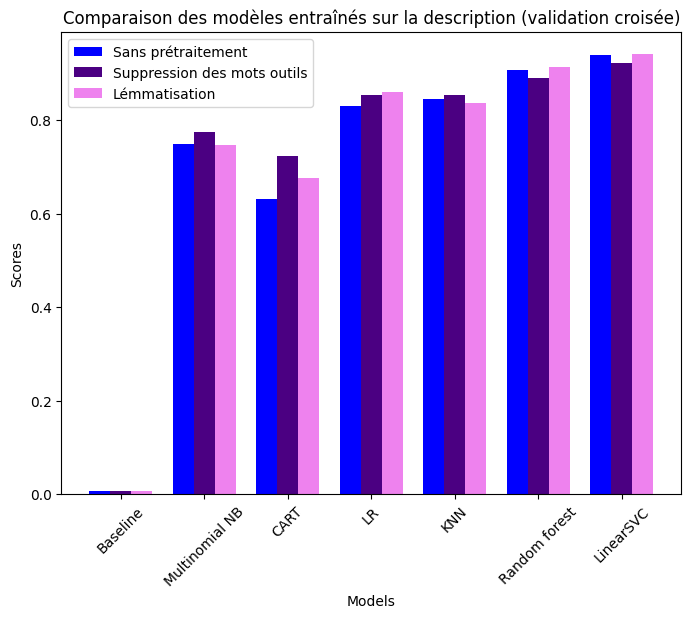

In [20]:
models_n = results_df["model_names"]
no_preprocessing_scores = results_df["no_preprocessing_scores"]
wosw_scores = results_df["wosw_scores"]
scores_lem = results_df["scores_lem"]


x = np.arange(len(models))
width = 0.25

fig, ax = plt.subplots(figsize=(8, 6))

bar1 = ax.bar(x - width, no_preprocessing_scores, width, label="Sans prétraitement", color="blue")
bar2 = ax.bar(x, wosw_scores, width, label="Suppression des mots outils", color="indigo")
bar3 = ax.bar(x + width, scores_lem, width, label="Lémmatisation", color="violet")

ax.set_xlabel("Models")
ax.set_ylabel("Scores")
ax.set_title("Comparaison des modèles entraînés sur la description (validation croisée)")
ax.set_xticks(x)
ax.set_xticklabels(models_n, rotation=45, ha='center')
ax.legend()

plt.show()

## Entraînement du modèle LinearSVC

On entraîne le modèle sur l'ensemble des données d'entraînement et on le teste sur les différentes colonnes du jeu de données `test`.

In [24]:
# description
X_train = train_df['description_tokens']
y_train = train_df.label_fr
X_test = test_df['description_tokens']
y_test = test_df.label_fr

column_trans = ColumnTransformer([(
         'description_tfidf', text_vectorizer, 'description_tokens')],
     remainder='drop')

classifier_pipeline = make_pipeline(
    text_vectorizer,
    LinearSVC()
)

classifier_pipeline.fit(X_train, y_train)

y_pred_des = classifier_pipeline.predict(X_test)
print("Classification report:\n{}".format(classification_report(y_test, y_pred_des)))

# sauvegarder le score f1 et calculer l'exactitude
accuracy_des = accuracy_score(y_test, y_pred_des)
f1_des = metrics.f1_score(y_test, y_pred_des, average = "macro")
print(f"Exactitude : {accuracy_des}")

Classification report:
                         precision    recall  f1-score   support

                   acné       1.00      1.00      1.00         3
               allergie       1.00      1.00      1.00         8
               arthrite       1.00      1.00      1.00         6
      asthme bronchique       1.00      1.00      1.00        11
                 dengue       1.00      0.67      0.80         6
                diabète       0.86      0.67      0.75         9
           hypertension       1.00      1.00      1.00         6
               impétigo       1.00      1.00      1.00         9
     infection fongique       0.83      1.00      0.91         5
               jaunisse       1.00      1.00      1.00         2
               migraine       0.83      0.83      0.83         6
              paludisme       1.00      1.00      1.00         2
              pneumonie       0.89      1.00      0.94         8
              psoriasis       1.00      0.89      0.94         9
 

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [23]:
# simple
X_test = test_df['simple_tokens']
y_test = test_df.label_fr

classifier_pipeline.fit(X_train, y_train)

y_pred_simple = classifier_pipeline.predict(X_test)
print("Classification report:\n{}".format(classification_report(y_test, y_pred_simple)))

accuracy_simple = accuracy_score(y_test, y_pred_simple)
f1_simple = metrics.f1_score(y_test, y_pred_simple, average = "macro")
print(f"Exactitude : {accuracy_simple}")

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Classification report:
                         precision    recall  f1-score   support

                   acné       1.00      0.67      0.80         3
               allergie       0.73      1.00      0.84         8
               arthrite       1.00      1.00      1.00         6
      asthme bronchique       1.00      1.00      1.00        11
                 dengue       0.80      0.67      0.73         6
                diabète       0.40      0.22      0.29         9
           hypertension       1.00      1.00      1.00         6
               impétigo       1.00      0.78      0.88         9
     infection fongique       0.71      1.00      0.83         5
               jaunisse       1.00      1.00      1.00         2
               migraine       1.00      0.50      0.67         6
              paludisme       1.00      1.00      1.00         2
              pneumonie       0.89      1.00      0.94         8
              psoriasis       1.00      0.56      0.71         9
 

In [25]:
#fautes

X_test = test_df['fautes_tokens']
y_test = test_df.label_fr

classifier_pipeline.fit(X_train, y_train)

y_pred_fautes = classifier_pipeline.predict(X_test)
print("Classification report:\n{}".format(classification_report(y_test, y_pred_fautes)))

accuracy_fautes = accuracy_score(y_test, y_pred_fautes)
f1_fautes = metrics.f1_score(y_test, y_pred_fautes, average = "macro")
print(f"Exactitude : {accuracy_fautes}")

Classification report:
                         precision    recall  f1-score   support

                   acné       1.00      0.67      0.80         3
               allergie       0.67      1.00      0.80         8
               arthrite       1.00      1.00      1.00         6
      asthme bronchique       1.00      0.91      0.95        11
                 dengue       1.00      0.17      0.29         6
                diabète       0.29      0.22      0.25         9
           hypertension       0.60      0.50      0.55         6
               impétigo       1.00      0.67      0.80         9
     infection fongique       0.62      1.00      0.77         5
               jaunisse       1.00      1.00      1.00         2
               migraine       0.75      0.50      0.60         6
              paludisme       1.00      0.50      0.67         2
              pneumonie       0.78      0.88      0.82         8
              psoriasis       0.62      0.56      0.59         9
 

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [26]:
final_results_df = pd.DataFrame(
    {
        "description" : [f1_des],
        "simple" : [f1_simple],
        "fautes" : [f1_fautes]

    }
)

final_results_df

,description,simple,fautes
0,0.947066,0.867263,0.729801


Les résultats quand on teste sur des nouvelles données de la colonne description sont très bons, comparables à ceux obtenus pendant la validation croisée. Au contraire, la performance se déteriore quand on teste sur des descriptions moins bien formulées, ce qui nous montre que le modèle n'est pas  très robuste à la variation.

Text(0, 0.5, 'F1 Score')

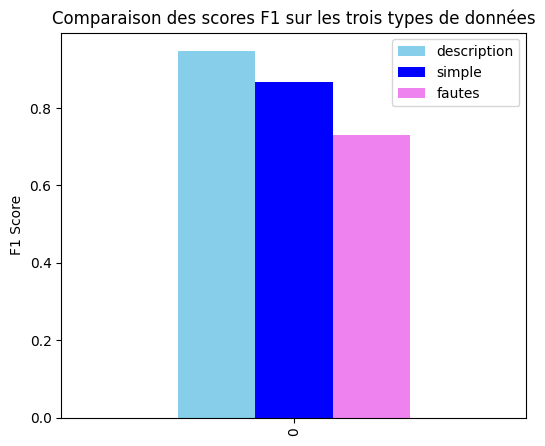

In [30]:
colors = ("skyblue", "blue", "violet")
final_results_df.plot(kind="bar", figsize=(6, 5), color=colors)
plt.title('Comparaison des scores F1 sur les trois types de données', fontsize=12)
plt.ylabel('F1 Score', fontsize=10)

#### Matrice de confusion pour description

La matrice de confusion nous permet de trouver les classes pour lesquelles le modèle a eu des difficultés puisque on trouve des valeurs non nulles hors de la diagonale.

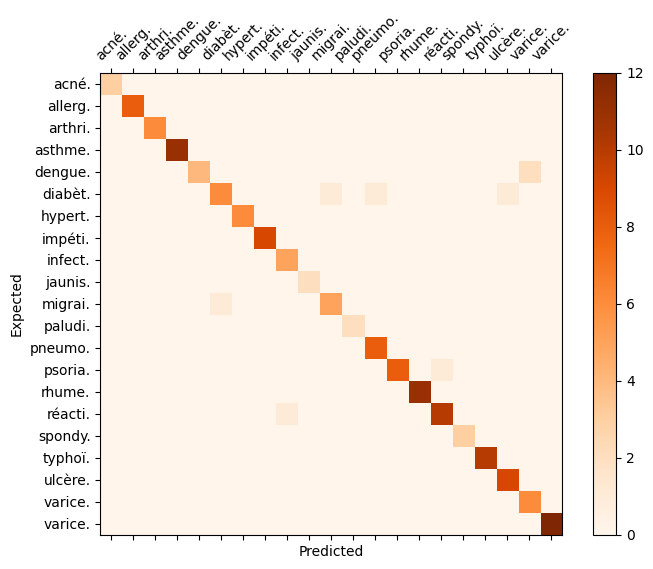

In [33]:
# matrice de confusion
# données de test : description

# Source : https://intellipaat.com/community/1611/sklearn-plot-confusion-matrix-with-labels
# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/

labels = np.unique(y_test)
cm =  confusion_matrix(y_test, y_pred_des, labels=labels)
confusion_df = pd.DataFrame(cm, index=labels, columns=labels)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
cax = ax.matshow(cm, interpolation='nearest', cmap=plt.cm.Oranges)
fig.colorbar(cax)
tick_marks = np.arange(len(labels))
labels_for_fig = [l[0:6]+'.' for l in labels]
plt.xticks(tick_marks, labels_for_fig, rotation=45)
plt.yticks(tick_marks, labels_for_fig)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

Pour la catégorie description, il n'y a pas beaucoup de confusions. La classe la plus souvent confondue est la varicelle, qui est le plus souvent confondue avec la dengue.

La catégorie avec laquelle il y a le plus de confusions est le diabète.La migraine, la pneumonie et l'ulcère sont souvent mal classés comme migraine.

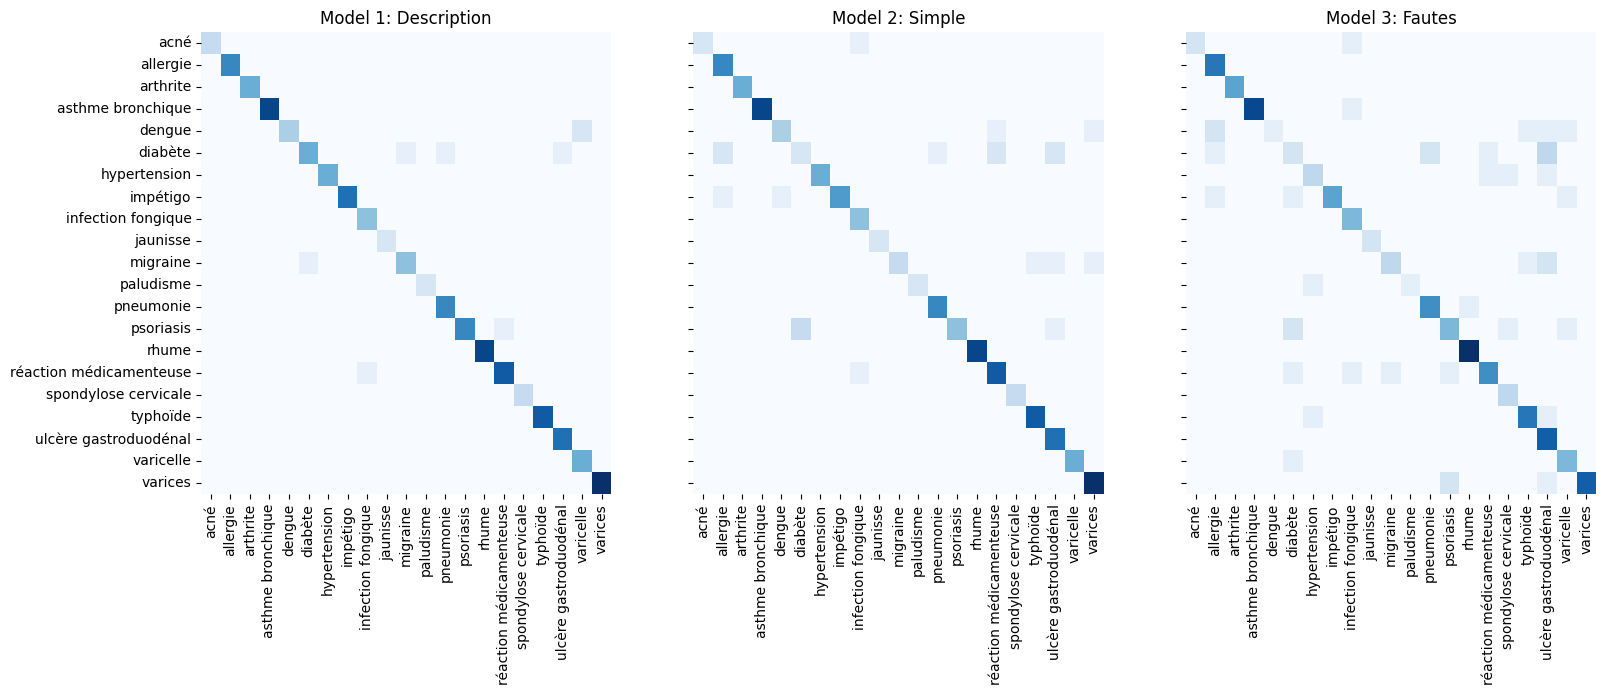

In [ ]:
labels = np.unique(y_test)

cm =  confusion_matrix(y_test, y_pred_des, labels=labels)
confusion_df = pd.DataFrame(cm, index=labels, columns=labels)

cm_simple = confusion_matrix(y_test, y_pred_simple, labels=labels)
confusion_df_simple = pd.DataFrame(cm_simple, index=labels, columns=labels)

cm_fautes = confusion_matrix(y_test, y_pred_fautes, labels=labels)
confusion_df_fautes = pd.DataFrame(cm_fautes, index=labels, columns=labels)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

sns.heatmap(confusion_df, fmt="d", cmap="Blues", ax=axes[0], cbar=False)
axes[0].set_title('Description')

sns.heatmap(confusion_df_simple, fmt="d", cmap="Blues", ax=axes[1], cbar=False)
axes[1].set_title('Simple')

sns.heatmap(confusion_df_fautes, fmt="d", cmap="Blues", ax=axes[2], cbar=False)
axes[2].set_title('Fautes')

plt.show()

Le modèle ayant des pires performances sur les données simples et celles avec des fautes, les confusions sont augmentées. Quand on teste sur les descriptions simples, la catégorie la mieux classée est varices, comme c'est le cas avec les descriptions originales. La catégorie la moins bien reconnue est diabète.

Pour les descriptions avec fautes, la catégorie la mieux reconnue est l'asthme bronchicque. L'urcèle gastroduodénal est souvent confondu avec le diabète, mais aussi avec l'hypertension et la migraine.

Les catégories les moins bien représentées dans le corpus (jaunisse, acné, palaudisme) sont bien reconnues, malgré le nombre restreint d'exemples. Cela nous montre qu'ils ont peut-être dans leurs descriptions un vocabulaire spécifique à la maladie, tandis que les catégories les plus mélangées ont du vocabulaire plus général, qui est commun pour plusieurs maladies.

In [35]:
# pour la comparaison avec les autres modèles
final_classique_df = pd.DataFrame(
    {
        "description" : [accuracy_des],
        "simple" : [accuracy_simple],
        "fautes" : [accuracy_fautes]

    }
)
final_classique_df

,description,simple,fautes
0,0.947368,0.868421,0.743421


In [37]:
!mkdir results
final_classique_df.to_csv("results/results_classique.csv", index=False)

mkdir: cannot create directory ‘results’: File exists
